# Учебный Проект → «Защита Персональных Данных» 🔐

## Цель проекта

> Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.
> 
> Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

Импортируем библиотеки 🎒

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from numpy.random import RandomState
from numpy.random import rand

from numpy.linalg import det

from matplotlib import rcParams

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Настроим вид графиков по+красоте ✨

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
# style MATPLOTLIBRC
custom_params = {
                'figure.figsize': (10, 6),
                'figure.facecolor': '#232425',
                'figure.dpi': 240,

                'legend.frameon': False,
                'legend.borderpad': 1.4,
                'legend.labelspacing': 0.7,
                'legend.handlelength': 0.7,
                'legend.handleheight': 0.7,

                'axes.facecolor': '#232425',
                'axes.labelcolor': '#EEEEEE',
                'axes.labelpad': 17,
                'axes.spines.left': False,
                'axes.spines.bottom': False,
                'axes.spines.right': False,
                'axes.spines.top': False,
                'axes.grid': False,

                'contour.linewidth': 0.0,

                'xtick.color': '#AAAAAA',
                'ytick.color': '#AAAAAA',
                'xtick.bottom': True,
                'xtick.top': False,
                'ytick.left': True,
                'ytick.right': False,
    
                "lines.color": '#EEEEEE',

                'text.color': '#EEEEEE',
    
                'font.family': 'sans-serif',
                # 'font.sans-serif': [
                #     'Helvetica',
                #     'Verdana',
                #     'Tahoma',
                #     'Trebuchet MS',
                #     'Arial',
                #     'Chevin'
                #     ]
                }

# rcParams.update(custom_params)

In [4]:
# set max columns to none
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

Константы.

In [5]:
RANDOM_SEED = 108108108
RANDOM_NP = RandomState(128) 
dpi_k = custom_params['figure.dpi'] / rcParams['figure.dpi']
px = 1/custom_params['figure.dpi']

Функции.

In [6]:
def baisic_df_info(data_df, title='Basic Info'):
    print(title, end='\n\n')
    print('Дубликатов:',
             len(data_df.loc[data_df.duplicated()].index),
          end='\n\n'
     )
    
    display(
        data_df.info(),
        data_df.sample(5),
        data_df.describe(),
    )

In [7]:
def to_px(size_px):
    px_density = int(
        round(
            size_px * px * dpi_k
        )
    )
    return px_density

In [8]:
def plot_hist(data, title='Histogram', custom_params=custom_params):
    
    num_col = 2
    num_row = int(
            len(data.columns) / num_col
        ) + (len(data.columns) % num_col)
    
    with mpl.rc_context(custom_params):
        fig, axs = plt.subplots(
            nrows=num_row,
            ncols=num_col,
            figsize=(
                to_px(960), to_px(960)),
            tight_layout=True
        )
        
        for n, col_name in enumerate(data.columns):
            ax_row = int(n/2)
            ax_col = n%2
            n_bins = len(data[col_name].unique())
                
            axs[ax_row, ax_col].hist(
                data[col_name],
                bins=n_bins,
                color='forestgreen'
            )
            axs[ax_row, ax_col].set_title(col_name)
        
        fig.suptitle(title, fontsize=16)
        
        if len(data.columns) % num_col:
            fig.delaxes(axs[-1, -1])

        plt.show()

In [9]:
def lin_reg_params(y_title, model, columns):
    print(
    y_title,
    round(model.intercept_, 5),
    sep=' = ',
    end=''
    )
    for k in range(model.n_features_in_):
        if model.coef_[k] > 0:
            print(' + ', end='')
        else:
            print(' - ', end='')
        print(
            abs(round(model.coef_[k], 5)),
            columns[k],
            sep='*',
            end=''
        )
    print()

## Загрузка данных

### 1.1. Загрузим файл и изучим данные

In [10]:
try:
    insurance_df = pd.read_csv(
        './datasets/insurance.csv',
    )
    
except FileNotFoundError:
    insurance_df = pd.read_csv(
        'https://code.s3.yandex.net/datasets/insurance.csv',
    )
    print('FYI datasets loaded via url')

In [11]:
baisic_df_info(insurance_df)

Basic Info

Дубликатов: 153

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

Пол  Возраст  Зарплата  Члены семьи  Страховые выплаты
4022    1     22.0   42700.0            1                  0
4325    0     29.0   45400.0            2                  0
920     1     34.0   22500.0            0                  0
1809    0     37.0   31800.0            3                  0
1423    0     41.0   43900.0            2                  0

Пол      Возраст      Зарплата  Члены семьи  Страховые выплаты
count  5000.000000  5000.000000   5000.000000  5000.000000        5000.000000
mean      0.499000    30.952800  39916.360000     1.194200           0.148000
std       0.500049     8.440807   9900.083569     1.091387           0.463183
min       0.000000    18.000000   5300.000000     0.000000           0.000000
25%       0.000000    24.000000  33300.000000     0.000000           0.000000
50%       0.000000    30.000000  40200.000000     1.000000           0.000000
75%       1.000000    37.000000  46600.000000     2.000000           0.000000
max       1.000000    65.000000  79000.000000     6.000000           5.000000

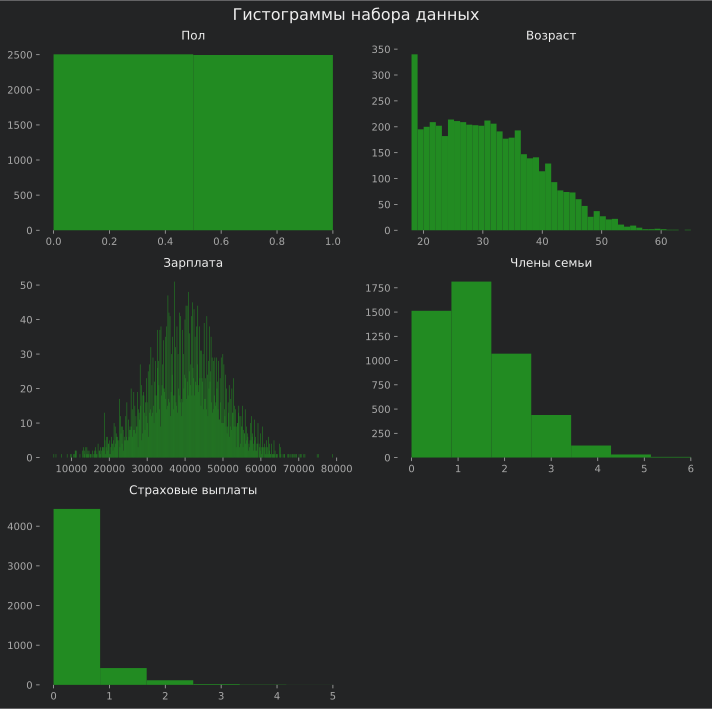

In [12]:
plot_hist(insurance_df, title='Гистограммы набора данных')

### 1.2. Подготовим данные

Удалим дубликаты.  
Будь у нас `user_id` можно было бы понять дубликаты это или одинаковые данные разных пользователей.  
Рисковать не будем, не велика потеря 153 строки.

In [13]:
insurance_df.drop_duplicates(keep='first', inplace=True)

In [14]:
nice_col_names = {
        'Пол': 'sex',
        'Возраст': 'age',
        'Зарплата': 'salary',
        'Члены семьи': 'family_members',
        'Страховые выплаты': 'payments'
    }
insurance_df.rename(
    columns=nice_col_names,
    inplace=True,
)

In [15]:
display(
    list(insurance_df.columns)
)

['sex', 'age', 'salary', 'family_members', 'payments']

In [16]:
target = insurance_df['payments']
target = target.astype('uint8')
features = insurance_df.drop(columns='payments')

In [17]:
features = features.astype(
        {
            'sex': 'uint8',
            'age': 'uint8',
            'salary': 'uint32',
            'family_members': 'uint8',
        },
        errors='raise',
    )

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
        features,
        target,
        test_size=0.25,
        random_state=RANDOM_SEED
    )

In [19]:
mm_scaler = MinMaxScaler()

In [20]:
mm_scaler.fit(features_train)

MinMaxScaler()

MinMaxScaler для `cross_val_score`

In [21]:
mm_scaler_cv = MinMaxScaler()

##### LinearRegression для `cross_val_score`

In [22]:
lin_reg = LinearRegression()

In [23]:
mm_scale_lin_reg = make_pipeline(
    mm_scaler_cv,
    lin_reg
)

In [24]:
folds = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_SEED
)
r2_scores = cross_val_score(
    mm_scale_lin_reg,
    features_train,
    target_train,
    scoring='r2',
    cv=folds
)

In [25]:
display(
    r2_scores
)

array([0.44521413, 0.43896842, 0.44454333, 0.44806853, 0.4270044 ])

In [26]:
features_train_scaled = mm_scaler.transform(features_train)

In [27]:
lin_reg.fit(features_train_scaled, target_train)

LinearRegression()

In [28]:
features_test_scaled = mm_scaler.transform(features_test)

In [29]:
target_pred = lin_reg.predict(features_test_scaled)

In [30]:
r2 = r2_score(target_test, target_pred)

In [31]:
display(
    r2
)

0.3776796681334704

## Умножение матриц

> ### Запрограммируйте этот алгоритм, применив матричные операции.

Транспонируем матрицу параметров чтобы многократно увеличить размерность матрицы ключа. Это, конечно, увеличивает время генерации такой матрицы и её проверку на обратимось, но зато грубым подбором|перебором такую шифровку уже не одолеть. Ева будет недовольна.

In [32]:
features_t = np.transpose(features)

Зададим матрицу `ключ` с проверкой обратимости.

In [33]:
n_col = len(features.index)

In [34]:
run = True
while run:
    key = rand(
        n_col, n_col
    )
    if det(key) != 0:
        run = False

/home/bionic/.local/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Умножим параметры на матрицу ключ.

In [35]:
to_alice = np.dot(features_t, key)

In [36]:
display(
    to_alice
)

array([[1.21784911e+03, 1.20193362e+03, 1.22114197e+03, ...,
        1.19878299e+03, 1.18874067e+03, 1.19818531e+03],
       [7.57561906e+04, 7.51533153e+04, 7.54606937e+04, ...,
        7.47524220e+04, 7.51101418e+04, 7.54705233e+04],
       [9.72144524e+07, 9.63922361e+07, 9.69298302e+07, ...,
        9.62818955e+07, 9.63106834e+07, 9.74830760e+07],
       [2.92447492e+03, 2.88148921e+03, 2.93052479e+03, ...,
        2.87155078e+03, 2.92352175e+03, 2.91726425e+03]])

In [37]:
plot_hist(
    pd.DataFrame(
        np.transpose(to_alice),
        columns=['sex', 'age', 'salary', 'family_members']
    ),
    title='Гистограммы зашифрованных параметров'
)

> ### Проверьте, что качество линейной регрессии из `sklearn` не отличается до и после преобразования.

Дешифруем матрицу обратно.

In [38]:
features_unencrypted = np.dot(to_alice, np.linalg.inv(key))

In [39]:
features_unencrypted = np.transpose(features_unencrypted)

In [40]:
display(
    features_unencrypted
)

array([[1.00000000e+00, 4.10000000e+01, 4.96000000e+04, 1.00000000e+00],
       [7.73070497e-12, 4.60000000e+01, 3.80000000e+04, 1.00000000e+00],
       [6.56541488e-12, 2.90000000e+01, 2.10000000e+04, 1.58024704e-11],
       ...,
       [1.36424205e-12, 2.00000000e+01, 3.39000000e+04, 2.00000000e+00],
       [1.00000000e+00, 2.20000000e+01, 3.27000000e+04, 3.00000000e+00],
       [1.00000000e+00, 2.80000000e+01, 4.06000000e+04, 1.00000000e+00]])

In [41]:
features_unencrypted = pd.DataFrame(
        features_unencrypted,
        columns=['sex', 'age', 'salary', 'family_members']
    )

In [42]:
display(
    features_unencrypted.head()
)

sex   age        salary  family_members
0  1.000000e+00  41.0  49600.000001    1.000000e+00
1  7.730705e-12  46.0  38000.000000    1.000000e+00
2  6.565415e-12  29.0  21000.000000    1.580247e-11
3  4.092726e-12  21.0  41700.000000    2.000000e+00
4  1.000000e+00  28.0  26100.000000    2.046363e-12

Ох уж этот `python` с его бинарными представлением `float`.  
Вернём типы данных к целым положительным значениям.  
Хотя и без этого модель работает так же как и до шифрования.  
`Проверено` ✍️

In [43]:
features_unencrypted = features_unencrypted.round(decimals=0)

In [44]:
features_unencrypted = features_unencrypted.astype(
        {
            'sex': 'uint8',
            'age': 'uint8',
            'salary': 'uint32',
            'family_members': 'uint8',
        },
        errors='raise',
    )

In [45]:
features_unencrypted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sex             4847 non-null   uint8 
 1   age             4847 non-null   uint8 
 2   salary          4847 non-null   uint32
 3   family_members  4847 non-null   uint8 
dtypes: uint32(1), uint8(3)
memory usage: 33.3 KB


In [46]:
features_unen_train, features_unen_test, target_train, target_test = train_test_split(
        features_unencrypted,
        target,
        test_size=0.25,
        random_state=RANDOM_SEED
    )

In [47]:
features_unen_train_sc = mm_scaler.transform(features_unen_train)
features_unen_test_sc = mm_scaler.transform(features_unen_test)

In [48]:
mm_scaler_cv_unen = MinMaxScaler()

In [49]:
lin_reg_unen = LinearRegression()

In [50]:
mm_scale_lin_reg_unen = make_pipeline(
    mm_scaler_cv_unen,
    lin_reg_unen
)

In [51]:
r2_unen_scores = cross_val_score(
    # mm_scale_lin_reg,
    mm_scale_lin_reg_unen,
    features_unen_train,
    target_train,
    scoring='r2',
    cv=folds
)

In [52]:
print( 
    r2_scores,
    '— R2 CV до шифровки'
)
print(
    r2_unen_scores,
    '— R2 CV после дешифровки'
)

[0.44521413 0.43896842 0.44454333 0.44806853 0.4270044 ] — R2 CV до шифровки
[0.44521413 0.43896842 0.44454333 0.44806853 0.4270044 ] — R2 CV после дешифровки


In [53]:
target_unen_pred = lin_reg_unen.fit(features_unen_train_sc, target_train)

In [54]:
target_unen_pred = lin_reg_unen.predict(features_unen_test_sc)

In [55]:
r2_unen = r2_score(target_test, target_unen_pred)

In [56]:
print( 
    r2,
    '— R2 test до шифровки'
)
print(
    r2_unen,
    '— R2 test после дешифровки'
)

0.3776796681334704 — R2 test до шифровки
0.3776796681334704 — R2 test после дешифровки


На `test` выборке всё ровно, с точностью до 16 знака.  
Для заново обученной модели и для изначальной.

> ### Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии?

Нет, качество после шифровки и дешифровки не изменилось..

> ### Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.

In [57]:
print('Bob', end='\t')
lin_reg_params('Y\u2080', lin_reg, features.columns)
print('Alice', end='\t')
lin_reg_params('Y\u2081', lin_reg_unen, features_unencrypted.columns)

Bob	Y₀ = -0.32279 + 0.01181*sex + 1.75228*age + 0.00935*salary - 0.0766*family_members
Alice	Y₁ = -0.32279 + 0.01181*sex + 1.75228*age + 0.00935*salary - 0.0766*family_members


Параметры равны.

## Алгоритм преобразования

> ### Предложите алгоритм преобразования данных для решения задачи.

Обозначения:
  
- $X$ — матрица признаков
- $K$ — обратимая матрица ключ
- $E$ — еденичная матрица

**1. Транспонируем матрицу признаков**
$$\large
X^T
$$
**2. Генерируем случайную и обратимую матрицу ключ**
$$\large
K
$$
$$
\det(K) \neq 0
$$
**3. Умножим признаки $X$ на матрицу ключ $K$**
$$\large
X \cdot K
$$
**4. Отправляем Алисе**:
- матрицу ключ
- открываем доступ к зашифрованным параметрам
- сообщаем имена столбцов параметров
- сообщаем что для дешифровки нужно $(X \cdot K^{-1})^T$
- чтобы значения параметров вновь стали целыми и положительными применить `.round` и задать типы данных (хотя и без этого почемуто работает корректно)
- можем поделится обученным `scaler`
- можем поделится обученной моделью или гиперпараметрами (если они будут)

> ### Обоснуйте, почему качество линейной регрессии не поменяется.

Свойство транспонирования матриц:
$$\large
(X^T)^T = X
$$
Операция умножения матриц **ассоциативна**:
$$\large
(X \cdot K) \cdot K^{-1} = X \cdot (K \cdot K^{-1})
$$
Обратная матрица:
$$\large
K \cdot K^{-1} = E
$$
$$
при \det(K) \neq 0
$$
Умножение на еденичную матрицу:
$$\large
X \cdot E = E  \cdot X = X
$$
**Таким образом:**
$$\large
X^T \cdot K \cdot K^{-1} = X^T \cdot E = X^T
$$
и далее
$$\large
(X^T)^T = X
$$

## Итог

В этом учебном проекте нужно было защитить данные клиентов страховой компании «Хоть потоп».  
- разработали такой алгоритм преобразования данных, чтобы было сложно восстановить персональную информацию из зашифрованных данных
- проверили алгоритм в работе:
    - обучили и протестировали модель до шифровки признаков
    - обучили и протестировали модель после шифровки и дешифровки признаков
    - сравнили `R2` моделей (они равны)
    - сравнили `параметры` моделей (они равны)

- обосновали корректность работы алгоритма свойствами матриц

🔆